#### 한국어 데이터로 챗봇 만들기

In [1]:
import torch                       # PyTorch 딥러닝 프레임워크 (텐서 연산 및 모델 구축)
import torch.nn as nn              # 신경망 계층 모듈 (예: Linear, Conv, RNN, Transformer 등)
import torch.nn.functional as F    # 신경망 함수 API (예: ReLU, softmax, dropout 등 함수형 연산)

from torch.utils.data import Dataset, DataLoader  
# Dataset: 사용자 정의 데이터셋 클래스 작성 시 상속받는 베이스 클래스
# DataLoader: Dataset에서 데이터를 배치 단위로 불러오고 셔플/병렬처리 지원

import torch.optim as optim        # 모델 학습을 위한 최적화 알고리즘 (Adam, SGD, RMSProp 등)
import torch.optim.lr_scheduler as lr_scheduler  
# 학습률(lr) 조정 스케줄러 (훈련 epoch이나 step에 따라 lr 점진적 증가/감소)

# !pip install sentencepiece       # SentencePiece 설치 (필요 시 주석 해제 후 실행)
import sentencepiece as spm        # SentencePiece 라이브러리 (서브워드 단위 토크나이저)

import math                        # 기본 수학 함수 모듈 (지수, 로그, 제곱근 등)
import os                          # 운영체제 관련 기능 (파일 경로, 디렉토리 관리 등)
import re                          # 정규 표현식 처리 모듈 (텍스트 전처리 시 패턴 매칭/치환)
import urllib.request              # 인터넷에서 파일 다운로드/요청 처리
import zipfile                     # ZIP 압축 파일 압축/해제 모듈

import numpy as np                 # 수치 연산 라이브러리 (다차원 배열, 행렬 연산)
import pandas as pd                # 데이터 분석 라이브러리 (CSV, 엑셀 등 테이블 형태 데이터 처리)
import matplotlib.pyplot as plt    # 데이터 시각화 라이브러리 (선 그래프, 히스토그램, 시각 자료 제작)

#### Step 1. 데이터 수집하기

In [2]:
# ==============================
# 한국어 챗봇 데이터셋 다운로드
# ==============================
# !wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
# → GitHub 저장소(songys/Chatbot_data)에 공개된 ChatbotData.csv 파일을 다운로드하는 명령어
# → 주피터 노트북 / 구글 코랩 환경에서는 "!"를 붙여 셸 명령어 실행 가능
# → ChatbotData.csv: 한국어 일상 대화 질문(Q) - 답변(A) 쌍으로 구성된 공개 챗봇 데이터셋

In [3]:
# ==============================
# 파일 경로 (ChatbotData.csv 위치 지정)
# ==============================
file_path = "~/work/transformer_chatbot/data/ChatbotData.csv"

# ==============================
# CSV 파일 로드
# ==============================
df = pd.read_csv(file_path)  
# ChatbotData.csv 파일을 읽어와서 Pandas DataFrame으로 변환

# 데이터프레임의 상위 5개 행 출력 (컬럼 구조 및 샘플 데이터 확인)
print(df.head())

# 전체 샘플(행)의 개수 출력
print("전체 샘플 수:", len(df))

# ==============================
# 데이터 정제 (결측치 및 중복 제거)
# ==============================
df = df.dropna(subset=['Q','A'])  
# Q, A 컬럼 중 하나라도 NaN 값이 있으면 해당 행 삭제

df = df.drop_duplicates(subset=['Q','A'])  
# Q, A 내용이 동일한 중복 행 삭제 (질문+답변 쌍 단위로 고유하게 유지)

# ==============================
# 정제 후 데이터 크기 출력
# ==================
print("정제 후 샘플 수:", len(df))

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
전체 샘플 수: 11823
정제 후 샘플 수: 11750


#### Step 2. 데이터 전처리하기

In [4]:
# ==============================
# 문장 전처리 함수 정의
# ==============================
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()  
    # 1) 모든 문장을 소문자로 변환하고 양쪽 공백 제거
    
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)  
    # 2) 문장부호 (?, ., !, ,) 앞뒤에 공백 추가 → 토큰화 시 분리 용이
    
    sentence = re.sub(r'[" "]+', " ", sentence)  
    # 3) 여러 개의 연속된 공백을 하나의 공백으로 치환
    
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)  
    # 4) 허용된 문자(한글, 알파벳, 숫자, 일부 문장부호) 외의 문자 제거
    
    sentence = sentence.strip()  
    # 5) 다시 양쪽 공백 제거
    
    return sentence

# ==============================
# 전처리 적용
# ==============================
df['Q'] = df['Q'].apply(preprocess_sentence)  # 질문(Q) 컬럼에 전처리 적용
df['A'] = df['A'].apply(preprocess_sentence)  # 답변(A) 컬럼에 전처리 적용

# ==============================
# (Q, A) 쌍 리스트 생성
# ==============================
pairs = list(zip(df['Q'], df['A']))  # Q, A를 튜플로 묶어 리스트로 변환

# 최종 데이터 쌍 개수 출력
print("최종 pair 수:", len(pairs))

# 샘플 5개 출력 (전처리 결과 확인용)
for i in range(5):
    print(pairs[i])

최종 pair 수: 11750
('12시 땡 !', '하루가 또 가네요 .')
('1지망 학교 떨어졌어', '위로해 드립니다 .')
('3박4일 놀러가고 싶다', '여행은 언제나 좋죠 .')
('3박4일 정도 놀러가고 싶다', '여행은 언제나 좋죠 .')
('ppl 심하네', '눈살이 찌푸려지죠 .')


#### Step 3. SentencePiece 사용하기

In [5]:
# =========================
# 말뭉치(corpus) 파일 저장
# =========================
corpus_file = 'corpus.txt'
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        f.write(q + '\n')  # 질문 문장 저장
        f.write(a + '\n')  # 답변 문장 저장

# =========================
# SentencePiece 모델 학습
# =========================
spm.SentencePieceTrainer.Train(
    input=corpus_file,         # 학습할 말뭉치 파일
    model_prefix='spm_korean', # 저장될 모델 이름 (spm_korean.model, spm_korean.vocab 생성)
    vocab_size=8000,           # 단어 사전 크기 (BPE 병합 단위 개수)
    character_coverage=1.0,    # 문자 커버율 (1.0 → 모든 문자 사용, 0.9995 → 드문 한자 제외 등)
    model_type="bpe",          # 모델 유형 (bpe, unigram, char, word 중 선택)
    max_sentence_length=999999,# 문장 최대 길이 제한 (기본은 4192, 여기서는 매우 크게 설정)
    bos_id=1, eos_id=2, pad_id=0, unk_id=3  # 특수 토큰 ID 지정
)

# =========================
# 학습된 SentencePiece 모델 로드
# =========================
sp = spm.SentencePieceProcessor()
sp.Load("spm_korean.model")  # spm_korean.model 불러오기

# =========================
# 토크나이저 동작 테스트
# =========================
sentence = "안녕하세요. 만나서 반갑습니다!"
sentence = preprocess_sentence(sentence)  # 전처리 적용
print("전처리 후:", sentence)  

print("Tokenized:", sp.encode(sentence, out_type=str))  # 서브워드 단위로 토큰화된 문자열
print("Encoded:", sp.encode(sentence, out_type=int))    # 토큰을 ID(정수) 시퀀스로 변환
print("Decoded:", sp.decode(sp.encode(sentence)))       # 다시 문장으로 복원

전처리 후: 안녕하세요 . 만나서 반갑습니다 !
Tokenized: ['▁안녕하세요', '▁.', '▁만나서', '▁반갑', '습니다', '▁!']
Encoded: [4578, 4, 1916, 4808, 149, 112]
Decoded: 안녕하세요 . 만나서 반갑습니다 !


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: spm_korean
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_

#### Step 4. 모델 구성하기

In [6]:
# ===============================
# 한국어 챗봇 데이터셋 클래스 정의
# ===============================
class KoreanDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:   # 질문(Q), 답변(A) 쌍 반복
            # 1) SentencePiece 토크나이즈 (문장을 서브워드 ID 리스트로 변환)
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) BOS/EOS 토큰 붙이기
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 문장 시작 토큰 (<s>)
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2  # 문장 종료 토큰 (</s>)

            q_tokens = [bos_id] + q_ids + [eos_id]  # 질문 시퀀스
            a_tokens = [bos_id] + a_ids + [eos_id]  # 답변 시퀀스

            # 3) 길이 제한 (max_length 초과 시 데이터 제외)
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 패딩 (고정 길이 max_length로 맞춤, pad=0 가정)
            q_tokens += [0] * (max_length - len(q_tokens))
            a_tokens += [0] * (max_length - len(a_tokens))

            # 5) 디코더 입력/출력 분리 (Teacher Forcing)
            dec_input = a_tokens[:-1]   # 마지막 토큰 제외 (디코더 입력)
            target   = a_tokens[1:]     # 첫 토큰 제외 (디코더가 예측해야 할 라벨)

            # 6) 하나의 샘플(dict)로 저장
            self.data.append({
                "enc_input": q_tokens,  # 인코더 입력
                "dec_input": dec_input, # 디코더 입력
                "target": target        # 정답 라벨
            })

    # 데이터 개수 리턴
    def __len__(self):
        return len(self.data)

    # 인덱스로 접근 시 tensor 반환
    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

# ===============================
# 데이터셋 생성 및 샘플 확인
# ===============================
dataset = KoreanDataset(pairs, sp, max_length=40)

for encoder_input, decoder_input, decoder_label in dataset:
    print("텐서 크기 :", encoder_input.size())          # 인코더 입력 텐서 크기
    print(encoder_input)                                # 인코더 입력 ID 시퀀스
    print(sp.decode(encoder_input.tolist()))            # 인코더 입력 디코딩 (문장 복원)
    print(decoder_input)                                # 디코더 입력 ID 시퀀스
    print(sp.decode(decoder_input.tolist()))            # 디코더 입력 디코딩
    print(decoder_label)                                # 정답 라벨 ID 시퀀스
    print(sp.decode(decoder_label.tolist()))            # 라벨 디코딩
    break                                               # 첫 번째 샘플만 확인

# ===============================
# DataLoader 생성 (배치 학습용)
# ===============================
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 배치 하나 꺼내서 크기 확인
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())   # (batch_size, max_length)
    print(decoder_input.size())   # (batch_size, max_length-1)
    print(decoder_label.size())   # (batch_size, max_length-1)
    break 

텐서 크기 : torch.Size([40])
tensor([   1, 5521, 6817, 3177,  112,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
12시 땡 !
tensor([   1, 4447,  213, 5885,    4,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하루가 또 가네요 .
tensor([4447,  213, 5885,    4,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하루가 또 가네요 .
torch.Size([32, 40])
torch.Size([32, 39])
torch.Size([32, 39])


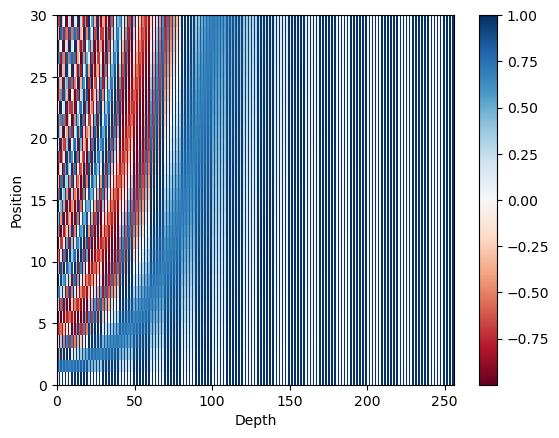

In [7]:
# ==============================
# 트랜스포머 위치 인코딩 (Positional Encoding)
# ==============================
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model      # 임베딩 차원 수
        self.position = position    # 최대 시퀀스 길이

        # 위치 인코딩 행렬 사전 계산
        self.pos_encoding = self._build_pos_encoding(position, d_model)

    # 각 위치(position)와 차원(i)에 대한 angle 값 계산
    # 공식: angle = position / (10000^(2*(i//2)/d_model))
    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    # 위치 인코딩 행렬 생성
    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)  
        # pos: [position, 1] → 각 토큰의 위치 인덱스 (0,1,2,...)

        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)    
        # i: [1, d_model] → 임베딩 차원의 인덱스 (0,1,2,...,d_model-1)

        # 각 위치 × 차원에 대한 angle 값 계산
        angle_rads = self._get_angles(pos, i, d_model)

        # 짝수 인덱스(0,2,4,...): sin 함수 적용
        sines = torch.sin(angle_rads[:, 0::2])
        # 홀수 인덱스(1,3,5,...): cos 함수 적용
        cosines = torch.cos(angle_rads[:, 1::2])

        # 최종 위치 인코딩 텐서 생성
        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines   # 짝수 차원에 사인 값 채움
        pos_encoding[:, 1::2] = cosines # 홀수 차원에 코사인 값 채움

        # shape: [1, position, d_model] → 배치 차원 추가
        pos_encoding = pos_encoding.unsqueeze(0)  
        return pos_encoding

    # 입력 x에 위치 인코딩 더하기
    def forward(self, x):
        # x.shape: [batch_size, seq_len, d_model]
        # pos_encoding 중 seq_len 길이만큼 잘라서 입력에 더함
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

# ==============================
# 위치 인코딩 시각화
# ==============================

sample_pos_encoding = PositionalEncoding(30, 256)  
# PositionalEncoding 객체 생성 (최대 시퀀스 길이=30, 임베딩 차원=256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')  
# 위치 인코딩 행렬을 컬러맵으로 시각화 (2D 이미지 형태)
# pos_encoding.shape = [1, position, d_model] → [30, 256]

plt.xlabel('Depth')   # x축: 임베딩 차원 (d_model)
plt.xlim((0, 256))    # x축 범위: 0 ~ 256
plt.ylabel('Position')# y축: 시퀀스 내 토큰 위치 (0~29)
plt.colorbar()        # 색상 값 범례 추가
plt.show()            # 그래프 출력

In [8]:
# ==============================
# Scaled Dot-Product Attention
# ==============================
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # query: (batch_size, heads, seq_len_q, depth)
    # key:   (batch_size, heads, seq_len_k, depth)
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len_k)
    # matmul 결과: (batch_size, heads, seq_len_q, seq_len_k)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화 (스케일링)
    # 이유: 내적 값이 커질수록 softmax 기울기 소실 방지
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크(mask) 적용
    # 특정 위치(예: 패딩 토큰, 미래 토큰)를 -1e9로 처리 → softmax 결과 0에 가까워짐
    if mask is not None:
        # mask shape: (batch_size, 1, 1, seq_len_k) or (batch_size, 1, seq_len_q, seq_len_k)
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weight 생성
    # dim=-1: key 방향(마지막 차원)으로 정규화
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 V(Value) 내적
    # output: (batch_size, heads, seq_len_q, depth)
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [9]:
# ==============================
# 멀티 헤드 어텐션 (Multi-Head Attention)
# ==============================
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads    # 어텐션 head 개수
        self.d_model = d_model        # 임베딩 차원 수

        # d_model은 반드시 num_heads로 나누어 떨어져야 함 (각 head가 동일한 depth를 가져야 함)
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads  # 각 head의 차원 수

        # Q, K, V를 얻기 위한 선형 변환 (Dense → PyTorch의 nn.Linear 사용)
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense   = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        # 여러 head의 결과를 합친 후 다시 선형 변환
        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        입력 텐서를 여러 head로 분리
        x: (batch_size, seq_len, d_model)
        -> view: (batch_size, seq_len, num_heads, depth)
        -> permute: (batch_size, num_heads, seq_len, depth)
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # head 차원을 앞으로 가져오기
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 형태 (패딩 마스크/룩어헤드 마스크)
        """
        batch_size = query.size(0)

        # 1) 입력을 각각 Q, K, V로 투영
        query = self.query_dense(query)   # (batch_size, seq_len, d_model)
        key   = self.key_dense(key)       # (batch_size, seq_len, d_model)
        value = self.value_dense(value)   # (batch_size, seq_len, d_model)

        # 2) head 분할 (멀티 헤드 구조로 변환)
        query = self.split_heads(query, batch_size)  # (batch_size, num_heads, seq_len, depth)
        key   = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3) Scaled Dot-Product Attention 적용
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # scaled_attention: (batch_size, num_heads, seq_len, depth)

        # 4) 여러 head의 결과를 다시 합치기
        # permute: (batch_size, seq_len, num_heads, depth)
        # contiguous → view 연산을 위해 메모리 연속화
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # reshape: (batch_size, seq_len, d_model)
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 5) 최종 선형 변환 (head 통합 후 투영)
        output = self.out_dense(concat_attention)

        return output

In [10]:
# ==============================
# 패딩 마스크 생성
# ==============================
def create_padding_mask(x):
    # 입력 x에서 값이 0인 위치(패딩 토큰)를 찾아 float형 1로 변환
    # 예: [1,2,0,3,0] -> [0,0,1,0,1]
    mask = (x == 0).float()

    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    # 어텐션 스코어 shape (batch, heads, seq_len_q, seq_len_k)에 브로드캐스트 되도록 변형
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

# ===== 패딩 마스크 테스트 =====
x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)       # (2, 5)
print("생성된 마스크 크기 :", mask.shape) # (2, 1, 1, 5)
print(mask)

# ==============================
# 룩어헤드(미래 정보 차단) 마스크 생성
# ==============================
def create_look_ahead_mask(x):
    seq_len = x.size(1)  # 입력 시퀀스 길이

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성
    # torch.tril(torch.ones(...)) -> 하삼각은 1, 상삼각은 0
    # 1 - tril(...) -> 하삼각(자기 자신 포함)은 0, 상삼각은 1
    # 즉, 미래 토큰은 1로 마스킹 처리됨
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크도 함께 고려 (batch_size, 1, 1, seq_len)
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)  # (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)  # (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.to(x.device)  # 디바이스 맞춤 (CPU/GPU)

    # 최종 마스크: 룩어헤드와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스크 처리)
    # 최종 shape: (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

# ===== 룩어헤드 마스크 테스트 =====
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])
첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])
두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [11]:
# ==============================
# Transformer 인코더 레이어 (하나의 블록)
# ==============================
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        self.mha = MultiHeadAttention(d_model, num_heads)  
        self.dropout1 = nn.Dropout(dropout)                # 정규화: 과적합 방지
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)       # LayerNorm (잔차 연결 후 안정화)

        # (2) 포지션별 피드포워드 신경망 (Position-wise FFN)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # 차원 확장
            nn.ReLU(),                   # 비선형 활성화
            nn.Linear(ff_dim, d_model)   # 원래 차원으로 축소
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 셀프 어텐션
        attn_output = self.mha(x, x, x, mask)   # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)      # 잔차 연결 + 정규화

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)             # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)    # 잔차 연결 + 정규화

        return out2

# ==============================
# Transformer 인코더 전체 (여러 블록 쌓기)
# ==============================
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,   # 단어 사전 크기
                 num_layers,   # 인코더 레이어 개수
                 ff_dim,       # 피드포워드 내부 차원
                 d_model,      # 임베딩 차원
                 num_heads,    # 어텐션 head 개수
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어 (단어 ID → 벡터)
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩 (위치 정보 추가)
        # position=vocab_size 로 설정했는데 보통은 max_seq_len을 넣는 경우가 많음
        self.pos_encoding = PositionalEncoding(position=MAX_LEN, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 여러 개 쌓기 (num_layers 만큼 반복)
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 입력 단어를 임베딩 + √d_model 로 스케일링
        # (논문에서: 큰 값 방지 및 안정적 학습을 위함)
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 더하기 + 드롭아웃
        x = self.pos_encoding(x)   # (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) 여러 개의 인코더 레이어를 순차적으로 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x   # (batch_size, seq_len, d_model)

In [12]:
# ==============================
# Transformer 디코더 레이어 (하나의 블록)
# ==============================
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # (1) 첫 번째 서브 레이어: 디코더 내부 셀프 어텐션
        # look-ahead mask 적용 → 미래 토큰 정보 차단
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # (2) 두 번째 서브 레이어: 인코더-디코더 어텐션
        # 디코더 query가 인코더 출력(enc_outputs)을 attend
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # (3) 세 번째 서브 레이어: 피드포워드 네트워크
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # 차원 확장
            nn.ReLU(),                   # 활성화
            nn.Linear(ff_dim, d_model)   # 원래 차원으로 축소
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃 (각 서브 레이어 출력 뒤에 적용)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 디코더 내부 셀프 어텐션
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # (2) 인코더-디코더 어텐션
        # query=디코더 출력, key/value=인코더 출력
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # (3) 피드포워드 네트워크
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

# ==============================
# Transformer 디코더 전체 (여러 블록 쌓기)
# ==============================
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,   # 단어 사전 크기
                 num_layers,   # 디코더 레이어 개수
                 ff_dim,       # 피드포워드 내부 차원
                 d_model,      # 임베딩 차원
                 num_heads,    # 어텐션 head 개수
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어 (단어 ID → 벡터)
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩 (위치 정보 추가)
        # 보통은 최대 시퀀스 길이(max_len)를 사용하지만,
        # 여기서는 vocab_size를 position으로 사용
        self.pos_encoding = PositionalEncoding(position=MAX_LEN, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 여러 개 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + √d_model 로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 추가 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x   # (batch_size, tgt_seq_len, d_model)

In [13]:
# ==============================
# Transformer 전체 모델
# ==============================
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,   # 단어 사전 크기
                 num_layers,   # 인코더/디코더 층 수
                 units,        # 피드포워드 네트워크 내부 차원 (ff_dim)
                 d_model,      # 임베딩 및 내부 표현 차원
                 num_heads,    # 멀티헤드 어텐션의 head 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # (1) 인코더 (Encoder)
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # (2) 디코더 (Decoder)
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # (3) 최종 출력층
        # 디코더 출력 (d_model 차원)을 vocab_size 차원으로 변환
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 구현에서는 name="transformer"를 붙이지만
        # 파이토치에서는 보통 클래스 이름 자체로 구분하기 때문에 필요 없음

    def forward(self, inputs, dec_inputs):
        # ==============================
        # 1) 인코더 입력 패딩 마스크
        # ==============================
        enc_padding_mask = create_padding_mask(inputs)     
        # shape: (batch_size, 1, 1, src_seq_len)
        # → 인코더에서 패딩 토큰 무시

        # ==============================
        # 2) 디코더 룩어헤드 + 패딩 마스크
        # ==============================
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  
        # shape: (batch_size, 1, tgt_seq_len, tgt_seq_len)
        # → 디코더에서 미래 단어를 못 보도록 차단 + 패딩 무시

        # ==============================
        # 3) 디코더의 인코더-디코더 어텐션에서 사용할 마스크
        # ==============================
        dec_padding_mask = create_padding_mask(inputs)        
        # shape: (batch_size, 1, 1, src_seq_len)
        # → 디코더가 인코더 출력 attend 시 패딩 무시

        # ==============================
        # 4) 인코더 수행
        # ==============================
        enc_outputs = self.encoder(
            x=inputs,                # (batch_size, src_seq_len)
            mask=enc_padding_mask     # (batch_size, 1, 1, src_seq_len)
        )
        # shape: (batch_size, src_seq_len, d_model)

        # ==============================
        # 5) 디코더 수행
        # ==============================
        dec_outputs = self.decoder(
            x=dec_inputs,            # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs, # (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )
        # shape: (batch_size, tgt_seq_len, d_model)

        # ==============================
        # 6) 최종 출력층 (단어 분포 예측)
        # ==============================
        logits = self.final_linear(dec_outputs)  
        # shape: (batch_size, tgt_seq_len, vocab_size)

        return logits

#### Step 5. 모델 학습 및 평가하기

In [14]:
# ==============================
# 예시: 하이퍼파라미터 설정
# ==============================
NUM_LAYERS = 2      # 인코더/디코더 층 수 (stacked layer 개수)
D_MODEL = 256       # 임베딩 및 내부 표현 차원 (토큰 임베딩 크기)
NUM_HEADS = 8       # 멀티헤드 어텐션에서의 head 수 (병렬 어텐션 개수)
UNITS = 512         # 피드포워드 신경망의 은닉 차원 (ff_dim)
DROPOUT = 0.1       # 드롭아웃 비율 (과적합 방지)
VOCAB_SIZE = 8000   # 단어 집합 크기 (SentencePiece 등으로 만든 vocab 크기)
MAX_LEN = 40        # 최대 문장 길이

# ==============================
# Transformer 모델 생성
# ==============================
model = Transformer(
    vocab_size=VOCAB_SIZE,  # 단어 집합 크기
    num_layers=NUM_LAYERS,  # 인코더/디코더 레이어 개수
    units=UNITS,            # 피드포워드 내부 차원
    d_model=D_MODEL,        # 임베딩 차원
    num_heads=NUM_HEADS,    # 어텐션 head 개수
    dropout=DROPOUT         # 드롭아웃 비율
)

# ==============================
# 모델 구조 출력
# ==============================
print(model)  # Transformer 전체 아키텍처 요약 출력

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

In [15]:
# ==============================
# 손실 함수 정의
# ==============================
# CrossEntropyLoss: 분류 문제에서 가장 많이 쓰이는 손실 함수
# ignore_index=sp.pad_id(): 패딩 토큰(<pad>)은 무시하고 손실 계산
# → 실제 단어 예측에 대해서만 학습이 이루어지도록 설정
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

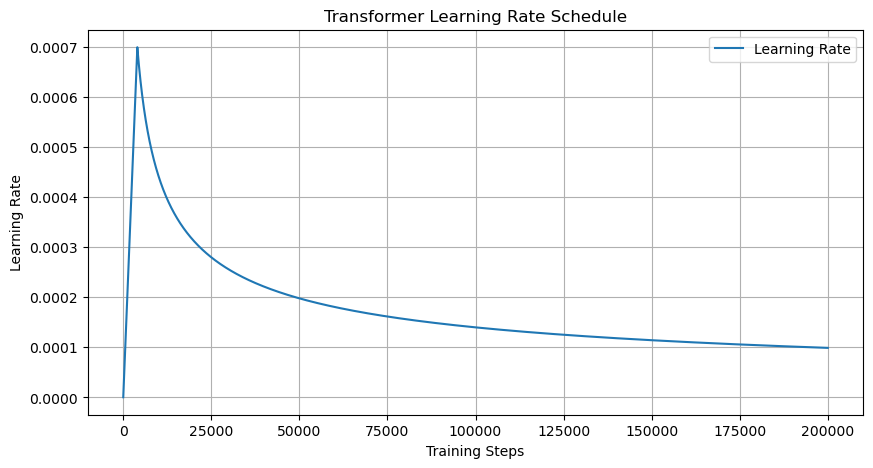

In [16]:
# ==============================
# 학습률 스케줄러 함수 (논문: Attention is All You Need)
# ==============================
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        # 공식: (d_model^(-0.5)) * min(step^(-0.5), step * warmup_steps^(-1.5))
        # - 초기에는 step * warmup_steps^(-1.5) → 학습률 증가(warmup)
        # - 이후에는 step^(-0.5) → 학습률 감소
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

# ==============================
# 하이퍼파라미터 설정
# ==============================
d_model = 512          # 임베딩 차원
warmup_steps = 4000    # 워밍업 단계 수
total_steps = 200000   # 전체 학습 스텝 수

# ==============================
# 학습률 스케줄 계산
# ==============================
steps = np.arange(1, total_steps + 1)  # 1 ~ total_steps
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# ==============================
# 학습률 변화 시각화
# ==============================
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# ==============================
# Optimizer 정의 (Adam)
# ==============================
# - Transformer 논문(Attention is All You Need)에서 권장한 Adam 설정
#   betas=(0.9, 0.98): 
#       β1=0.9 → 1차 모멘텀(gradient 평균) 유지
#       β2=0.98 → 2차 모멘텀(gradient 제곱 평균) 유지
#   eps=1e-9: 0으로 나누는 상황 방지용 작은 수 (수치적 안정성)
#   lr=1.0: base learning rate (실제 학습률은 스케줄러에서 조정됨)
#            → LambdaLR 스케줄러의 lr_lambda와 곱해져 최종 lr이 결정됨
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9, lr=1.0)

# ==============================
# Scheduler 정의 (LambdaLR)
# ==============================
# - 학습률을 get_lr_lambda() 함수의 규칙에 따라 조절
# - 초기에는 warmup 단계까지 점점 증가 → 이후 감소
scheduler = lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000)
)

# ==============================
# 정확도 계산 함수
# ==============================
def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size) → 모델 출력 (logits)
    y_true: (batch_size, seq_len)             → 정답 라벨
    """
    preds = y_pred.argmax(dim=-1)  # 가장 확률 높은 단어 선택 (batch_size, seq_len)

    # pad 토큰은 정확도 계산에서 제외
    mask = (y_true != pad_id)

    # 예측과 정답이 일치하면서 pad가 아닌 경우만 correct로 계산
    correct = (preds == y_true) & mask

    # 정확도 = (맞춘 개수 / 실제 pad가 아닌 단어 개수)
    acc = correct.float().sum() / mask.float().sum()
    return acc

# ==============================
# Device 설정 (GPU/CPU)
# ==============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델을 해당 디바이스로 이동
model = model.to(device)

In [18]:
# ==============================
# 한 스텝 학습 함수
# ==============================
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 1) 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # 2) 손실 함수 계산
    loss = loss_function(logits.permute(0, 2, 1), target)  
    # logits: (batch, vocab_size, seq_len), target: (batch, seq_len)

    # 3) 역전파
    loss.backward()
    optimizer.step()

    # 4) 손실 값과 정확도 반환
    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

# ==============================
# 전체 학습 루프 (Early Stopping 추가)
# ==============================
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    # 시각화를 위한 손실/정확도 기록
    losses, accs = [], []

    # Early Stopping용 변수
    best_acc = 0.0            # 지금까지의 최고 정확도
    epochs_no_improve = 0     # 향상 없는 에폭 카운트

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0

        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 100 step마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        # 에폭 평균
        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

        # 기록 저장
        losses.append(float(avg_loss))
        accs.append(float(avg_acc))

    return losses, accs

In [19]:
%%time
# Jupyter/Colab 매직 명령어
# - 셀 전체 실행에 걸린 시간을 측정해 출력

# ==============================
# 모델 학습 시작 (Early Stopping 적용)
# ==============================
losses, accs = train(
    model=model,                # 학습할 Transformer 모델
    dataloader=dataloader,      # 학습 데이터 (배치 단위)
    optimizer=optimizer,        # 옵티마이저 (Adam)
    loss_function=loss_function,# 손실 함수 (CrossEntropyLoss, pad 무시)
    scheduler=scheduler,        # 학습률 스케줄러 (warmup + decay)
    num_epochs=30,              # 최대 학습 에폭 수
    device=device,              # 연산 장치 (GPU or CPU)
)

[Epoch 1, Step 0] Loss: 9.1861, Acc: 0.0000
[Epoch 1, Step 100] Loss: 7.5524, Acc: 0.2796
[Epoch 1, Step 200] Loss: 6.6344, Acc: 0.2838
[Epoch 1, Step 300] Loss: 6.1193, Acc: 0.2770
Epoch 1 Completed - Avg Loss: 7.1017, Avg Acc: 0.2325
[Epoch 2, Step 0] Loss: 6.0044, Acc: 0.2667
[Epoch 2, Step 100] Loss: 5.8277, Acc: 0.2915
[Epoch 2, Step 200] Loss: 5.9838, Acc: 0.2766
[Epoch 2, Step 300] Loss: 5.2538, Acc: 0.3421
Epoch 2 Completed - Avg Loss: 5.6937, Avg Acc: 0.2997
[Epoch 3, Step 0] Loss: 5.2871, Acc: 0.3097
[Epoch 3, Step 100] Loss: 5.4225, Acc: 0.2913
[Epoch 3, Step 200] Loss: 5.2376, Acc: 0.3270
[Epoch 3, Step 300] Loss: 5.3971, Acc: 0.2806
Epoch 3 Completed - Avg Loss: 5.2115, Avg Acc: 0.3182
[Epoch 4, Step 0] Loss: 5.0354, Acc: 0.2793
[Epoch 4, Step 100] Loss: 4.5426, Acc: 0.3303
[Epoch 4, Step 200] Loss: 4.8049, Acc: 0.3364
[Epoch 4, Step 300] Loss: 5.0036, Acc: 0.3013
Epoch 4 Completed - Avg Loss: 4.7133, Avg Acc: 0.3436
[Epoch 5, Step 0] Loss: 4.2842, Acc: 0.3565
[Epoch 5, St

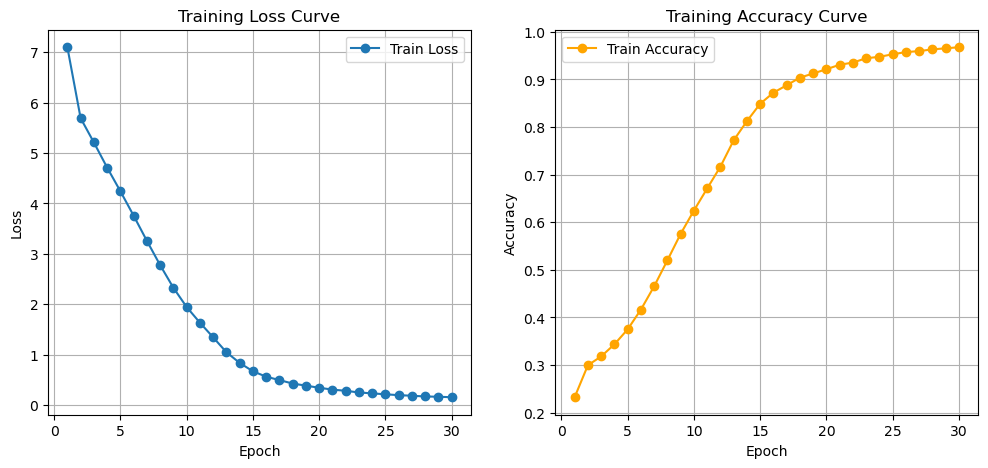

In [20]:
# ==============================
# 학습 곡선 시각화 함수
# ==============================
def plot_training_curves(losses, accs):
    epochs = range(1, len(losses)+1)  # x축: 에폭 번호 (1부터 시작)

    plt.figure(figsize=(12, 5))  # 가로 12, 세로 5 크기 그래프

    # (1) Loss Curve
    plt.subplot(1, 2, 1)  # 1행 2열 중 1번째 subplot
    plt.plot(epochs, losses, marker='o', label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)

    # (2) Accuracy Curve
    plt.subplot(1, 2, 2)  # 1행 2열 중 2번째 subplot
    plt.plot(epochs, accs, marker='o', color="orange", label="Train Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Curve")
    plt.legend()
    plt.grid(True)

    plt.show()  # 최종 그래프 출력

# ==============================
# 실제 학습 곡선 시각화 실행
# ==============================
plot_training_curves(losses, accs)

#### Step 6. 문장 생성

In [21]:
# ==============================
# 디코더 추론 함수 (Greedy Search)
# ==============================
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()   # 문장 시작 토큰 ID
    END_TOKEN = tokenizer.eos_id()     # 문장 종료 토큰 ID
    MAX_LENGTH = 40                    # 최대 생성 길이

    # (1) 입력 문장 전처리
    sentence = preprocess_sentence(sentence)

    # (2) 인코더 입력 생성: [START] + 인코딩된 입력 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)  # shape (1, seq_len)

    # (3) 디코더 입력 초기화: [START] 토큰만 포함
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 평가 모드 (dropout 비활성화)
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # (4) 모델 forward
            # 입력: (enc_input, dec_input)
            # 출력: (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # (5) 마지막 step의 로짓 추출 (shape: (1, vocab_size))
            last_step_logits = logits[:, -1, :]

            # (6) argmax → 가장 확률 높은 토큰 선택 (Greedy decoding)
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # (7) 종료 토큰 예측 시 중단
            if predicted_id.item() == END_TOKEN:
                break

            # (8) 디코더 입력에 예측 토큰 추가 (다음 step의 입력으로 사용)
            predicted_id = predicted_id.unsqueeze(0)  # shape (1, 1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # (9) 최종 결과 시퀀스 (tensor → list 변환)
    # 예: [START_TOKEN, ..., 예측된 토큰들...]
    output_sequence = dec_input.squeeze(0).tolist()

    return output_sequence

# ==============================
# 문장 생성 함수
# ==============================
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # (1) 디코더 인퍼런스로 토큰 시퀀스 생성
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # (2) 토큰 ID → 텍스트 디코딩
    # - pad, START, END 같은 특수 토큰 제외
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    # (3) 입력/출력 결과 출력
    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [22]:
# ==============================
# 테스트용 문장 생성
# ==============================

sentence = '안녕하세요.'     # 입력 문장 (예시)

# sentence_generation:
# - 입력 문장 전처리
# - Transformer 모델을 통해 디코딩 (Greedy Search)
# - 최종 토큰 시퀀스를 문장으로 디코딩해 출력
# model  : 학습된 Transformer 모델
# sentence: 테스트할 입력 문장
# sp     : SentencePiece 토크나이저
# device : 연산 장치 (CPU / GPU)
sentence_generation(model, sentence, sp, device)

입력 : 안녕하세요.
출력 : 안녕하세요 .


'안녕하세요 .'

In [23]:
sentence = '오늘 하루는 어때?'
sentence_generation(model, sentence, sp, device)

입력 : 오늘 하루는 어때?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [24]:
sentence = '나 오늘 기분이 좋지가 않아.'
sentence_generation(model, sentence, sp, device)

입력 : 나 오늘 기분이 좋지가 않아.
출력 : 좋은 소식이었으면 좋겠어요 .


'좋은 소식이었으면 좋겠어요 .'

In [25]:
sentence = '배고파!'
sentence_generation(model, sentence, sp, device)

입력 : 배고파!
출력 : 얼른 맛난 음식 드세요 .


'얼른 맛난 음식 드세요 .'

In [26]:
sentence = '사랑해!'
sentence_generation(model, sentence, sp, device)

입력 : 사랑해!
출력 : 하늘 만큼 땅 만큼 사랑해요 .


'하늘 만큼 땅 만큼 사랑해요 .'

In [27]:
sentence = '트랜스포머를 공부중이야.'
sentence_generation(model, sentence, sp, device)

입력 : 트랜스포머를 공부중이야.
출력 : 서로 깊게 알게되면서 더 쉽게 가까워질 수 있을 거예요 .


'서로 깊게 알게되면서 더 쉽게 가까워질 수 있을 거예요 .'

In [28]:
sentence = '점심을 추천해줘.'
sentence_generation(model, sentence, sp, device)

입력 : 점심을 추천해줘.
출력 : 즐거운 시간 보내시길 바랍니다 .


'즐거운 시간 보내시길 바랍니다 .'

In [29]:
sentence = '놀러가고싶다.'
sentence_generation(model, sentence, sp, device)

입력 : 놀러가고싶다.
출력 : 저도요 !


'저도요 !'

In [30]:
sentence = '영어 공부는 어려워.'
sentence_generation(model, sentence, sp, device)

입력 : 영어 공부는 어려워.
출력 : 매일 조금씩 해보세요 .


'매일 조금씩 해보세요 .'

In [31]:
sentence = '귀여운 동물을 좋아해.'
sentence_generation(model, sentence, sp, device)

입력 : 귀여운 동물을 좋아해.
출력 : 마음이 따뜻할 것 같아요 .


'마음이 따뜻할 것 같아요 .'

#### Review

이번 프로젝트에서는 Attention is All You Need의 트랜스포머 구조를 활용해 한국어 챗봇을 구현했다. 한국어의 특성상 공백과 특수문자 처리, 병렬 데이터 구축, 토크나이징 과정이 특히 중요했으며, 이를 통해 학습 데이터셋을 정리할 수 있었다.

트랜스포머 구조를 직접 구현하면서 내부 동작 방식에 대한 이해도 깊어졌다. 하지만 처음 학습을 진행했을 때는 전혀 수렴이 되지 않았다. 원인을 찾아보니 학습률 스케줄러 때문이었다. Adam 옵티마이저의 기본 학습률(0.001)이 스케줄러와 곱해지면서 너무 작은 값으로 시작되었고, 그 결과 파라미터가 거의 업데이트되지 않았던 것이다. 이를 lr=1.0으로 조정해 스케줄러만 사용하도록 바꾸자 학습이 안정적으로 진행되었고, 한국어 입력에 자연스럽게 답변하는 챗봇을 완성할 수 있었다.

다만 아직 포지셔널 인코딩을 보캡 사이즈 기준으로 해야 할지, 문장의 최대 길이 기준으로 해야 할지에 대한 의문이 남아 있다. 개인적으로는 문장의 최대 길이가 맞다고 생각된다. 왜냐하면 포지셔널 인코딩은 각 문장의 토큰 위치에 더해지는 벡터인데, 이를 보캡 사이즈 기준으로 설정하면 임베딩 벡터와 차원이 맞지 않아 합산이 불가능하기 때문이다. 결국 문장의 길이에 따라 위치 정보를 부여하는 것이 자연스럽다고 본다. 이 부분은 좀 더 검증이 필요하다.

앞으로는 더 많은 한국어 대화 데이터셋을 활용하고, 트랜스포머의 깊이를 늘려 더욱 자연스럽고 완성도 높은 챗봇을 만들어 보고 싶다. 또한 인코더, 디코더, 인코더-디코더 구조를 기반으로 한 다양한 트랜스포머 모델도 직접 실험해 볼 계획이다.